<a href="https://colab.research.google.com/github/mikepang98/TimeSeriesLSTM/blob/main/Multivariate_Multi_Step_Medium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference : https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

Reference : https://towardsdatascience.com/predictive-analytics-time-series-forecasting-with-gru-and-bilstm-in-tensorflow-87588c852915

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from pandas import DataFrame , concat
from sklearn.metrics import mean_absolute_error , mean_squared_error
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from numpy import mean , concatenate
from math import sqrt
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation
from numpy import array , hstack
from tensorflow import keras
import tensorflow as tf

#from google.colab import drive
#drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
url = 'Dataset.csv'
dataset = pd.read_csv(url)

In [3]:
x_1 = dataset['x1']
x_2 = dataset['x2']
y = dataset['y']

x_1 = x_1.values
x_2 = x_2.values
y = y.values

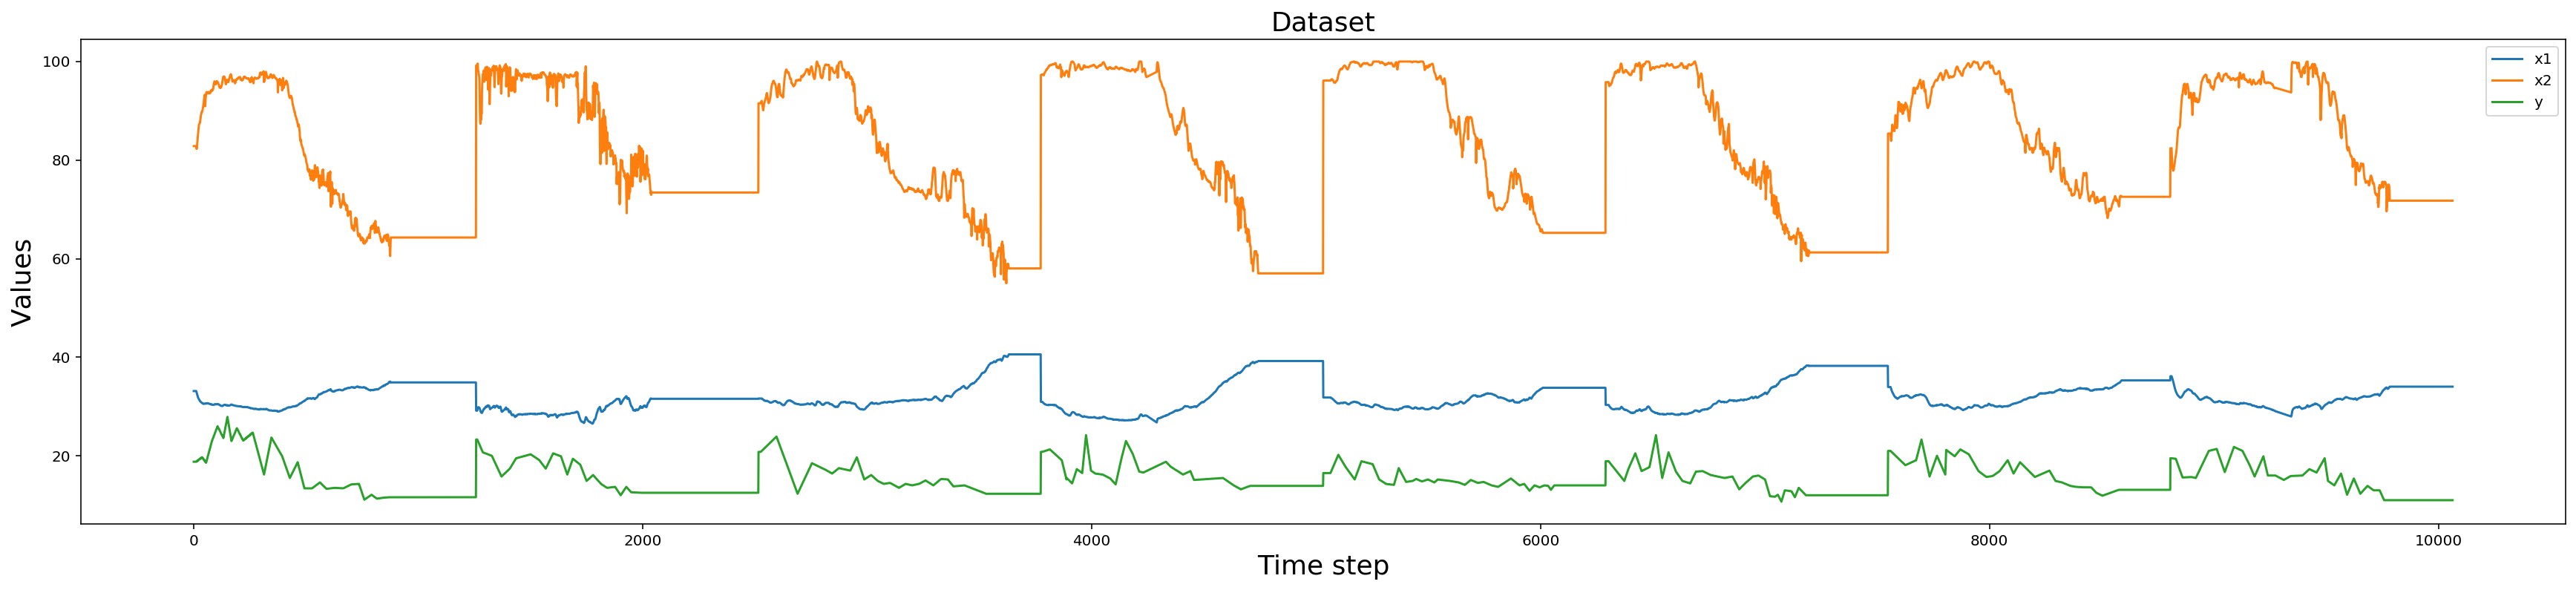

In [4]:
plt.figure(figsize=(30, 6))
plt.plot(x_1[:10064] , label='x1')
plt.plot(x_2[:10064] , label='x2')
plt.plot(y[:10064] , label='y')
plt.legend(loc='upper right')
plt.title("Dataset" ,  fontsize=18)
plt.xlabel('Time step' ,  fontsize=18)
plt.ylabel('Values' , fontsize=18)
plt.legend()
plt.show()

In [5]:
# convert to [rows, columns] structure
x_1 = x_1.reshape((len(x_1), 1))
x_2 = x_2.reshape((len(x_2), 1))
y = y.reshape((len(y), 1))

print ("x_1.shape" , x_1.shape) 
print ("x_2.shape" , x_2.shape) 
print ("y.shape" , y.shape) 

x_1.shape (35224, 1)
x_2.shape (35224, 1)
y.shape (35224, 1)


In [6]:
# normalization features
scaler = MinMaxScaler(feature_range=(0, 1))
x_1_scaled = scaler.fit_transform(x_1)
x_2_scaled = scaler.fit_transform(x_2)
y_scaled = scaler.fit_transform(y)

# horizontally stack columns
dataset_stacked = hstack((x_1_scaled, x_2_scaled, y_scaled))

print ("dataset_stacked.shape" , dataset_stacked.shape) 

dataset_stacked.shape (35224, 3)


In [7]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


In [8]:
# choose a number of time steps #change this accordingly
n_steps_in, n_steps_out = 60 , 30 

# covert into input/output
X, y = split_sequences(dataset_stacked, n_steps_in, n_steps_out)

print ("X.shape" , X.shape) 
print ("y.shape" , y.shape) 

X.shape (35136, 60, 2)
y.shape (35136, 30)


In [9]:
split = 1258*25
train_X , train_y = X[:split, :] , y[:split, :]
test_X , test_y = X[split:, :] , y[split:, :]

n_features = train_X.shape[2]


In [10]:
print ("train_X.shape" , train_X.shape) 
print ("train_y.shape" , train_y.shape) 
print ("test_X.shape" , test_X.shape) 
print ("test_y.shape" , test_y.shape) 
print ("n_features" , n_features)

train_X.shape (31450, 60, 2)
train_y.shape (31450, 30)
test_X.shape (3686, 60, 2)
test_y.shape (3686, 30)
n_features 2


**LSTM Model Parameter Setting**

In [11]:
#optimizer learning rate
opt = keras.optimizers.Adam(learning_rate=0.01)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(n_steps_out))
model.add(Activation('linear'))
model.compile(loss='mse' , optimizer=opt , metrics=['mse'])


In [12]:
# Fit network
history = model.fit(train_X , train_y , epochs=60 , steps_per_epoch=25 , verbose=1 ,validation_data=(test_X, test_y) ,shuffle=False)


Epoch 1/60
25/25 [==============================] - 10s 348ms/step - loss: 16050825.6251 - mse: 16050825.6251 - val_loss: 0.1021 - val_mse: 0.1021
Epoch 2/60
25/25 [==============================] - 8s 328ms/step - loss: 0.1015 - mse: 0.1015 - val_loss: 0.0798 - val_mse: 0.0798
Epoch 3/60
25/25 [==============================] - 8s 317ms/step - loss: 0.0726 - mse: 0.0726 - val_loss: 0.0209 - val_mse: 0.0209
Epoch 4/60
25/25 [==============================] - 8s 317ms/step - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0154 - val_mse: 0.0154
Epoch 5/60
25/25 [==============================] - 8s 322ms/step - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0133 - val_mse: 0.0133
Epoch 6/60
25/25 [==============================] - 8s 338ms/step - loss: 0.0182 - mse: 0.0182 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 7/60
25/25 [==============================] - 9s 343ms/step - loss: 0.0184 - mse: 0.0184 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 8/60
25/25 [==============================] - 8s 335ms/

Evaluation



In [14]:
# Test Data Batch 1 , Test Data Batch 2 , Test Data Batch 3
url_test = 'Test Data Batch 1.csv'
dataset_test_ok = pd.read_csv(url_test)
dataset_test_ok.head()

,y,x1,x2
0,22.2,33.50,72.41
1,22.2,33.61,75.22
2,22.2,33.78,79.00
3,22.2,33.91,75.72
4,22.2,34.02,67.09


In [15]:
# read test data
x1_test = dataset_test_ok['x1'].values
x2_test = dataset_test_ok['x2'].values
y_test = dataset_test_ok['y'].values # no need to scale

# convert to [rows, columns] structure
x1_test = x1_test.reshape((len(x1_test), 1))
x2_test = x2_test.reshape((len(x2_test), 1))
y_test = y_test.reshape((len(y_test), 1))

x1_test_scaled = scaler.fit_transform(x1_test)
x2_test_scaled = scaler.fit_transform(x2_test)


In [16]:
def prep_data(x1_test_scaled , x2_test_scaled , y_test , start , end , last):
    #prepare test data X
    dataset_test = hstack((x1_test_scaled, x2_test_scaled))
    dataset_test_X = dataset_test[start:end, :]
    test_X_new = dataset_test_X.reshape(1, dataset_test_X.shape[0] , dataset_test_X.shape[1])

    #prepare past and groundtruth
    past_data = y_test[:end , :]
    dataset_test_y = y_test[end:last , :]
    scaler1 = MinMaxScaler(feature_range=(0, 1))
    scaler1.fit(dataset_test_y)

    # predictions
    y_pred = model.predict(test_X_new)
    y_pred_inv = scaler1.inverse_transform(y_pred)
    y_pred_inv = y_pred_inv.reshape(n_steps_out,1)
    y_pred_inv = y_pred_inv[:,0]
    
    return y_pred_inv , dataset_test_y , past_data

# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name , start , end):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print("Test Data from {} to {}".format(start, end))
    print('Mean Absolute Error: {:.2f}'.format(mae))
    print('Root Mean Square Error: {:.2f}'.format(rmse))
    print('')
    print('')

# Plot history and future
def plot_multistep(history, prediction1 , groundtruth , start , end):
    
    plt.figure(figsize=(20, 4))

    y_mean = mean(prediction1)

    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction1)))

    plt.plot(np.arange(range_history), np.array(history), label='History')
    plt.plot(range_future, np.array(prediction1),label='Forecasted with LSTM')
    plt.plot(range_future, np.array(groundtruth),label='GroundTruth')

    plt.legend(loc='upper right')
    plt.title("Test Data from {} to {} , Mean = {:.2f}".format(start, end, y_mean) ,  fontsize=18)
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('y-value' , fontsize=18)

In [17]:
# Plot history and future
def plot_multistep(history, prediction1 , groundtruth , start , end):
    plt.figure(figsize=(20, 4))
    y_mean = mean(prediction1)
    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction1)))
    plt.plot(np.arange(range_history), np.array(history), label='History')
    plt.plot(range_future, np.array(prediction1),label='Forecasted with LSTM')
    plt.plot(range_future, np.array(groundtruth),label='GroundTruth')
    plt.legend(loc='upper right')
    plt.title("Test Data from {} to {} , Mean = {:.2f}".format(start, end, y_mean) ,  fontsize=18)
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('y-value' , fontsize=18)

Test Data from 120 to 180
Mean Absolute Error: 0.48
Root Mean Square Error: 0.55


Test Data from 180 to 240
Mean Absolute Error: 0.24
Root Mean Square Error: 0.29




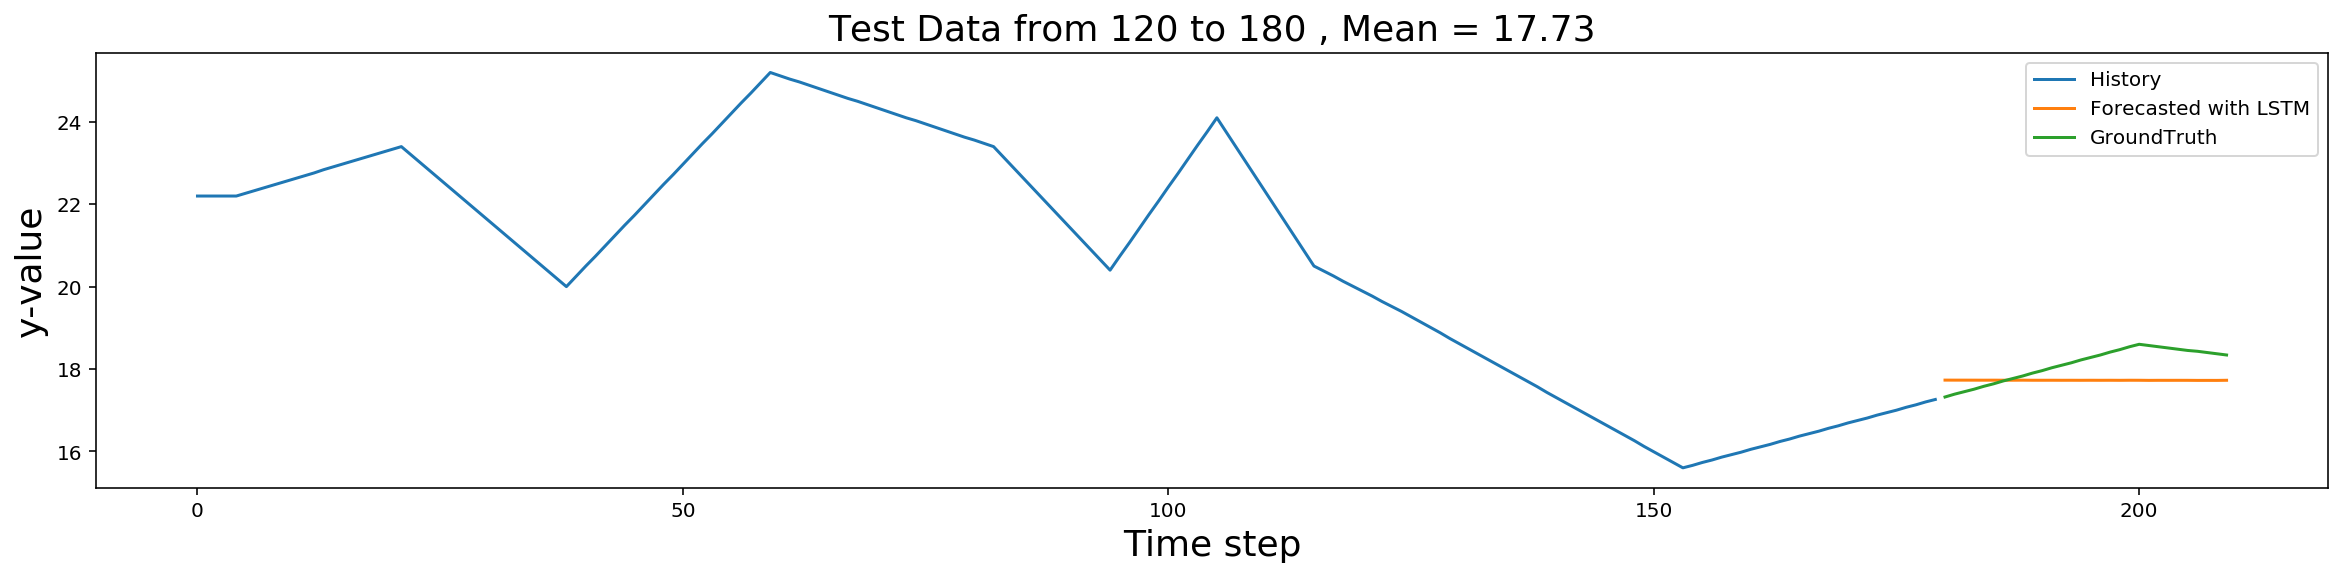

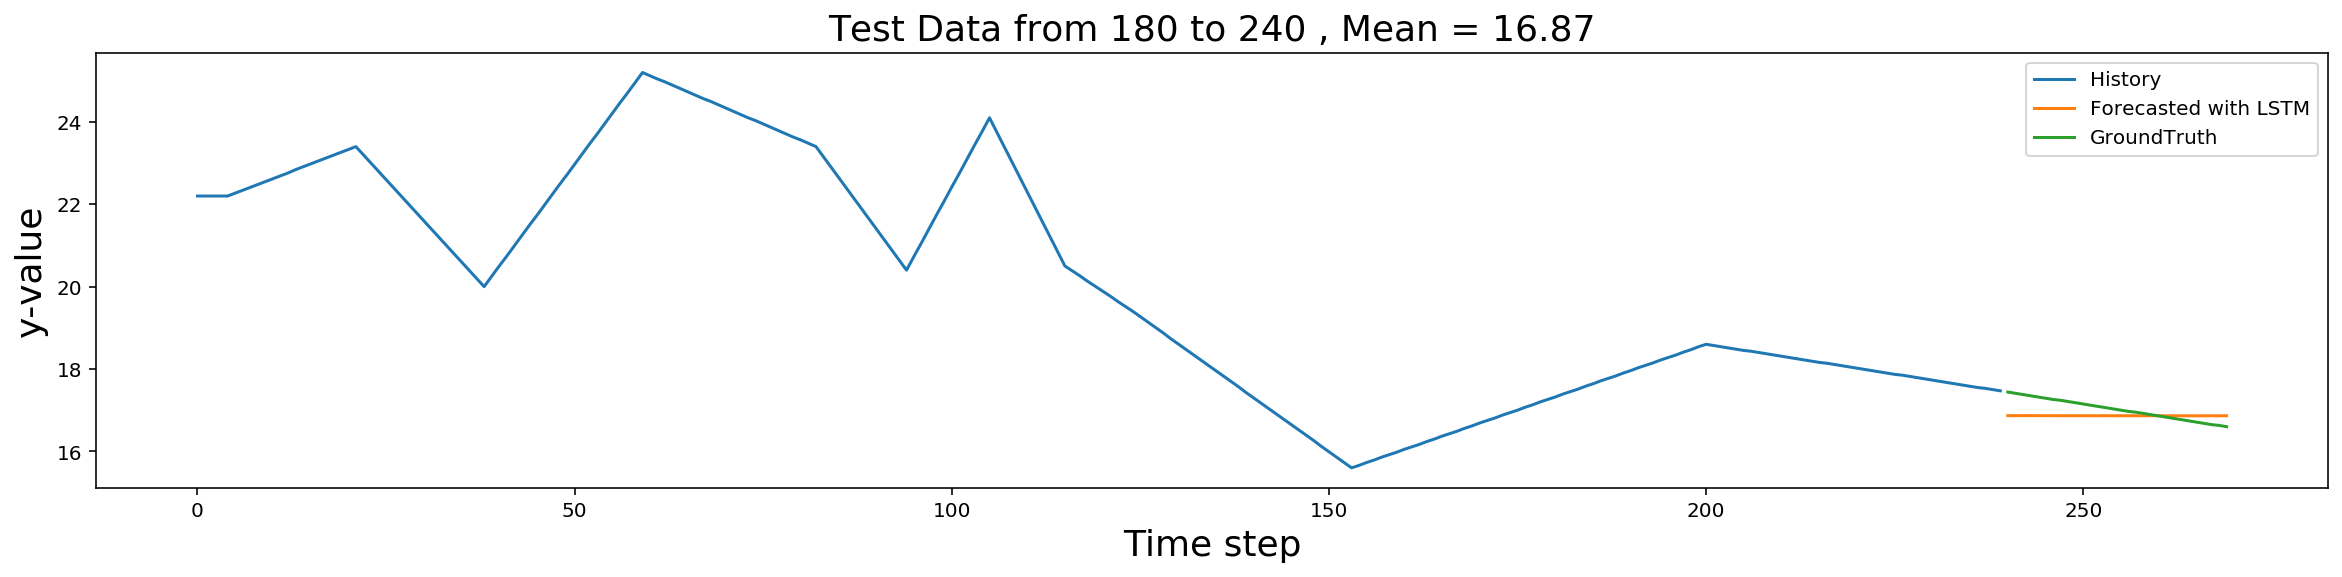

In [18]:
for i in range(120,240,60):
    start = i
    end = start + n_steps_in 
    last = end + n_steps_out 
    y_pred_inv , dataset_test_y , past_data = prep_data(x1_test_scaled , x2_test_scaled , y_test , start , end , last) 
    evaluate_prediction(y_pred_inv , dataset_test_y, 'LSTM' , start , end) 
    plot_multistep(past_data , y_pred_inv , dataset_test_y , start , end) 


Save & Load


In [19]:
# model_url = '/Directory/Filename.h5'
# model.save(model_url)
# print("Saved")

In [20]:
# model_url = '/Directory/Filename.h5'
# model = load_model(model_url)
# print("Loaded")
# model.summary()

In [21]:
prediction1

NameError: name 'prediction1' is not defined